<a href="https://colab.research.google.com/github/eliasyilma/Smart_Compose/blob/master/Smart_Compose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow-gpu==1.12.0
#!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
#!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
#!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
#!apt-get update
#!apt-get install cuda=9.0.176-1
%tensorflow_version 1.13.0
import numpy as np
np.random.seed(42)
import tensorflow as tf
#tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.0`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
file = open('/content/drive/My Drive/f_dataset2.txt', 'r')
def preprocess(data):
    output=[]
    for phrase in data:
        phrase=phrase.replace('\n','')
        phrase=phrase+" <end>"
        output.append(phrase)
    return output

def get_vocab(data):
    vocab=set()
    for phrase in data:
        words=phrase.split(' ')
        vocab.update(words)
    return vocab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

text = file.read().lower()
file=open("/content/drive/My Drive//f_dataset2.txt")
corpus = [line for line in file]
print('corpus length:', len(corpus))

corpus length: 410


In [0]:
vocab= (get_vocab(preprocess(corpus)))
print(vocab)
word_indices = dict((w, i) for i, w in enumerate(vocab))
indices_word = dict((i, w) for i, w in enumerate(vocab))
# print(chars)
print(word_indices)
print(indices_word)
print(word_indices['<end>'])
# unique_chars=len(chars)
# print(f'unique chars: {unique_chars}')
# chars= sorted(list(set(text)))
# char_indices = dict((c, i) for i, c in enumerate(chars))
# indices_char = dict((i, c) for i, c in enumerate(chars))
# print(chars)
# print(char_indices)
# print(indices_char)
# unique_chars=len(chars)
# print(f'unique chars: {unique_chars}')

{'', 'solution', 'Here’s', 'anytime.', 'interested', 'we’d', 'inform', 'spoke!', 'Merry', 'tell', 'your', 'specific?', 'get', 'Further', 'hate', 'possibly', 'address].', 'forward', 'Best,', 'inconvenience.', 'seems', 'you’ll', 'today.', 'cancel', 'should.', 'resolved.', 'with.', 'clarify', 'an', 'Come', 'Christmas!', 'thought', '10', 'weekend.', 'main', '[product].', "I'll", 'arrive.', 'Is', '[word]?', 'best', 'hands.', 'it’s', 'discussed', 'finds', 'expecting', 'wonderful', 'pleased', 'these', 'our', 'conversation', 'regarding', 'attached', 'me', 'please', 'Issue', 'urgent,', 'hearing', 'meeting,', 'how', 'solution,', "don't", 'attaching', 'consideration', 'caused.', 'information,', 'finish', 'Congratulations', 'updated', 'enjoying', 'holiday.', 'interested,', 'propose', 'tommorrow.', 'request.', "you're", '[time]', 'take', 'It’s', 'last', 'doing', 'delivery', 'project.', 'I', 'time.', 'up', 'reminder', 'happened?', 'contains', 'situation', 'not', 'to...?', 'if', 'life!', 'You', "we'l

In [0]:
SEQUENCE_LENGTH = 2
step = 1
sentences = []
next_words = []
def generate_in_out(data):
    sentences=[]
    words=[]
    for line in data:
        line =line
        token_list=line.split(' ')
        for i in range(0, len(token_list) - SEQUENCE_LENGTH, step):
            sentences.append(token_list[i: i + SEQUENCE_LENGTH])
            words.append(token_list[i + SEQUENCE_LENGTH])
    return sentences,words

sentences,next_words=generate_in_out(preprocess(corpus))    
print(f'num training examples: {len(sentences)}')

# for i in range(0, len(text) - SEQUENCE_LENGTH, step):
#     sentences.append(text[i: i + SEQUENCE_LENGTH])
#     next_chars.append(text[i + SEQUENCE_LENGTH])


num training examples: 2344


In [0]:
print(sentences[0:30])
print(next_words[0:30])
preprocess(corpus)[1]



[['Dear', 'Sir/Madam,'], ['Sir/Madam,', ''], ['Dear', '[Name],'], ['[Name],', ''], ['Hello', '[Name],'], ['[Name],', ''], ['Hi', '[Name],'], ['[Name],', ''], ['Hi', 'Team,'], ['Team,', ''], ['Good', 'morning'], ['morning', '[Name],'], ['[Name],', ''], ['Good', 'afternoon'], ['afternoon', '[Name],'], ['[Name],', ''], ['I', 'recently'], ['recently', 'read'], ['I', 'recently'], ['recently', 'heard'], ['heard', 'about'], ['about', ''], ['', ''], ['and', 'would'], ['would', 'like'], ['like', 'to'], ['to', 'know'], ['know', ''], ['I', 'would'], ['would', 'be']]
['', '<end>', '', '<end>', '', '<end>', '', '<end>', '', '<end>', '[Name],', '', '<end>', '[Name],', '', '<end>', 'read', '<end>', 'heard', 'about', '', '', '<end>', 'like', 'to', 'know', '', '<end>', 'be', 'interested']


'Dear [Name],  <end>'

In [0]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(vocab)), dtype=np.bool)
y = np.zeros((len(sentences), len(vocab)), dtype=np.bool)
print(f'input vector: {X.shape}')
print(f'output vector: {y.shape}')
#for each character in each sentence, set the
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        X[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1

input vector: (2344, 2, 683)
output vector: (2344, 683)


In [0]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(vocab))))
model.add(Dense(len(vocab)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               415744    
_________________________________________________________________
dense_4 (Dense)              (None, 683)               88107     
_________________________________________________________________
activation_4 (Activation)    (None, 683)               0         
Total params: 503,851
Trainable params: 503,851
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=100, shuffle=True).history

Train on 2226 samples, validate on 118 samples
Epoch 1/100
2226/2226 [==============================] - 1s 632us/step - loss: 5.2108 - acc: 0.1572 - val_loss: 5.3058 - val_acc: 0.0847
Epoch 2/100
2226/2226 [==============================] - 0s 93us/step - loss: 4.2025 - acc: 0.2556 - val_loss: 5.1958 - val_acc: 0.1949
Epoch 3/100
2226/2226 [==============================] - 0s 94us/step - loss: 3.6367 - acc: 0.3266 - val_loss: 5.4847 - val_acc: 0.0847
Epoch 4/100
2226/2226 [==============================] - 0s 93us/step - loss: 3.0528 - acc: 0.4066 - val_loss: 5.3451 - val_acc: 0.1356
Epoch 5/100
2226/2226 [==============================] - 0s 100us/step - loss: 2.5349 - acc: 0.4695 - val_loss: 5.6062 - val_acc: 0.1610
Epoch 6/100
2226/2226 [==============================] - 0s 95us/step - loss: 2.1031 - acc: 0.5413 - val_loss: 5.9180 - val_acc: 0.1525
Epoch 7/100
2226/2226 [==============================] - 0s 89us/step - loss: 1.7070 - acc: 0.5921 - val_loss: 6.2548 - val_acc: 0.1525

In [0]:
model.save('/content/drive/My Drive/keras_model.h5')
pickle.dump(history, open("/content/drive/My Drive/history.p", "wb"))

In [0]:
model = load_model('/content/drive/My Drive/keras_model.h5')
history = pickle.load(open("/content/drive/My Drive/history.p", "rb"))

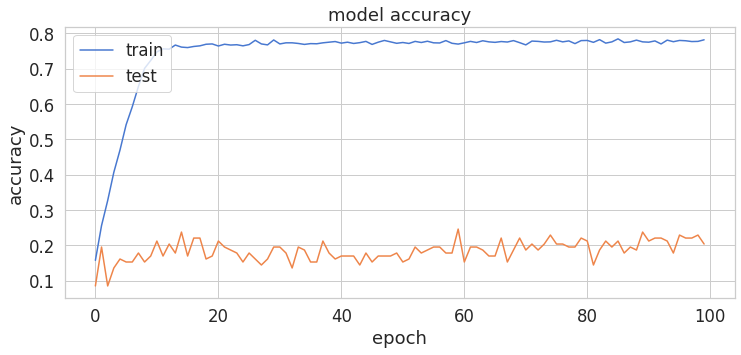

In [0]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

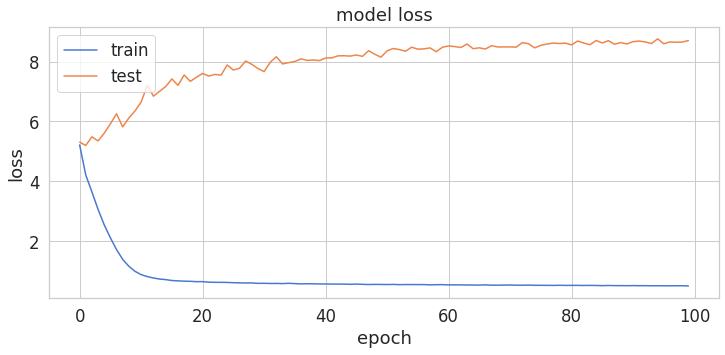

In [0]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [0]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(vocab)))    
    for t, word in enumerate(text.split(' ')):
        x[0, t, word_indices[word]] = 1.
        
    return x
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

print(prepare_input('Hope'))

print(word_indices['you'])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
657


In [0]:
def predict_completion(text,n):
    original_text = text
    generated = text
    completion = ''
    bag=[]
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_word = indices_word[next_index]      
        text = text.split(' ')[1]+' '+next_word
        print(text)
        if next_word=='<end>':
          return completion
        completion = completion + ' ' +next_word
        bag.append(next_word)
        if len(bag) >= n or next_word == ' ' or next_word == '':
            return completion

In [0]:
def predict_completions(text, n=3):
    print(text)
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return predict_completion(text,n)
    #return [indices_word[idx] + predict_completion(text + indices_word[idx]) for idx in next_indices]

In [0]:
quotes = [
    "apologize for"]

In [0]:
import time
st=time.time()
for q in quotes:
    seq = q
    print(seq)
    print(predict_completions(seq, 4))
    print()
en=time.time()
print('time elapsed',en-st)

to apologize
to apologize
apologize for
for the
the following
following reason.
 for the following reason.

time elapsed 0.03401827812194824
